# EMNIST DATASET 
# Test on classes imbalance

In [1]:
import tensorflow.keras as keras
from tensorflow.keras.datasets import mnist
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# the data, split between train and validation sets
train = pd.read_csv('./Emnist/emnist-digits-train.csv')
test = pd.read_csv('./Emnist/emnist-digits-test.csv')


In [3]:
y_train = train.iloc[:,0]
y_test = test.iloc[:,0]
set(y_train)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [4]:
x_train = train.iloc[: , 1:]
x_test = test.iloc[:,1:]
set(y_train)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [6]:
x_train.shape

(239999, 784)

In [7]:
x_train.max().max()

255

In [8]:
x_train.min().min()

0

In [8]:
x_train.shape

(239999, 784)

Normalization and shape for model

In [9]:
x_train = x_train.to_numpy().reshape(-1,28,28,1)/255
x_train.shape
x_valid = x_valid.to_numpy().reshape(-1,28,28,1)/255
y_train =  y_train.to_numpy()
y_valid = y_valid.to_numpy()


Emnist Dataset : Here we see the difference from the Mnist dataset, numbers are harder to decifer. 

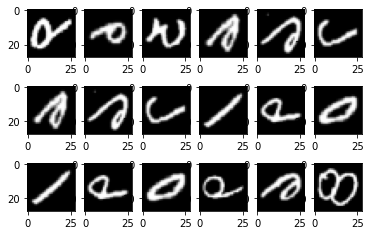

In [10]:
import matplotlib.pyplot as plt
figure, axis = plt.subplots(3, 6)
for i in range(6):
    for j in range(3): 
        image = x_train[3*j+i]
        axis[j,i].imshow(image, cmap='gray')
plt.show()

Here were are interested to study classes imbalance, so we are focusing our work on binary classes 0 and 1 

In [11]:
train_index= y_train[:] <= 1

In [12]:
x_train= x_train[train_index]

In [13]:
y_train = y_train[train_index]

In [14]:
x_train.shape

(48000, 28, 28, 1)

In [15]:
y_train.shape

(48000,)

In [16]:
valid_index = y_valid[:] <= 1

In [17]:
x_valid = x_valid[valid_index]
y_valid = y_valid[valid_index]

In [18]:
x_valid.shape

(7999, 28, 28, 1)

In [19]:
y_valid.shape

(7999,)

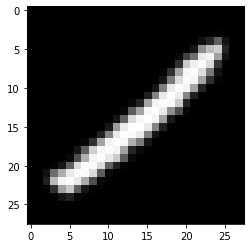

In [20]:
import matplotlib.pyplot as plt

image = x_train[0]
plt.imshow(image, cmap='gray')

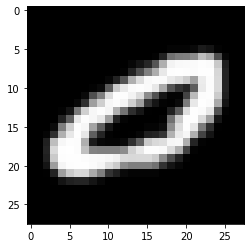

In [21]:
import matplotlib.pyplot as plt

image = x_train[1]
plt.imshow(image, cmap='gray')

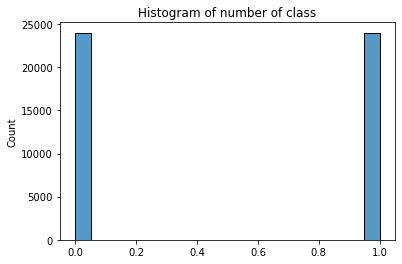

In [22]:
sns.histplot(y_train)
plt.title('Histogram of number of class')
plt.show()

We can see that classes are balanced here. 

Data preprocessing

In [23]:
from sklearn.model_selection import train_test_split
train_split, test_split, train_labels_split, test_labels_split = train_test_split(x_train, y_train, random_state=0)


In [24]:
validation_split = x_valid
validation_labels_split = y_valid

In [25]:
type(train_labels_split)

numpy.ndarray

In [26]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models, transforms
import time
import copy
from torch.utils.data import DataLoader, Dataset

In [27]:
# define custom dataset
class MyDataset(Dataset):
    def __init__(self, feature, target=None, transform=None):

        self.X = feature
        self.Y = target
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.transform is not None:
            return self.transform(self.X[idx]), self.Y[idx]
        elif self.Y is None:
            return [self.X[idx]]
        return self.X[idx], self.Y[idx]

In [28]:
# data reshape
test_data = torch.from_numpy(test_split.reshape((-1,1,28,28)))
train_data = torch.from_numpy(train_split.reshape((-1,1,28,28)))
train_labels_data =  torch.from_numpy(train_labels_split)
validation_data = torch.from_numpy(validation_split.reshape((-1,1,28,28)))
validation_labels_data =  torch.from_numpy(validation_labels_split)

In [31]:
train_labels_split.shape

(36000,)

In [32]:
train_set = MyDataset(train_data.float(), train_labels_data)
valid_set = MyDataset(validation_data.float(), validation_labels_data)
test_set = MyDataset(test_data.float())
batch_size = 128
train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle = False)

In [33]:
# calculate mean and std of train_set for normalize
data = next(iter(train_loader))
mean = data[0].mean()
std = data[0].std()

# set transformation option
transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomAffine(degrees = 30),
        transforms.RandomPerspective(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)])

# augmented train_set
augmented_train_set = MyDataset(train_data.float(), train_labels_data, transform=transform)

# combine original set with augmented set
datasets = []
datasets.append(train_set)
datasets.append(augmented_train_set)
train_set = torch.utils.data.ConcatDataset(datasets)

# redefine train_loader
train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True)

In [35]:
from tqdm import tqdm
from time import sleep
from tqdm import trange

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dataloaders = {'train': train_loader, 'val': valid_loader}
dataset_sizes= {'train': len(train_set), 'val': len(valid_set)}

def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    pbar = trange(num_epochs, unit="carrots")
    for epoch in pbar:
        sleep(0.5)
        #print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        #print('-' * 10)

        # Each epoch has a training and validation phase
        pbar.set_description(f"Epoch {epoch}")
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            #print('{} Loss: {:.4f} Acc: {:.4f}'.format(
            #    phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        #print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    pbar.close()
    return model

In [36]:
epochs = 5

# make resnet 18 model
model_ft = models.resnet18(weights='DEFAULT')

# change input layer
# the default number of input channel in the resnet is 3, but our images are 1 channel. So we have to change 3 to 1.
# nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) <- default
model_ft.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) 

# change fc layer
# the number of classes in our dataset is 10. default is 1000.
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

# train model
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, dataloaders, dataset_sizes,
                       num_epochs=epochs)

Epoch 4: 100%|██████████| 5/5 [52:52<00:00, 634.48s/carrots]

Training complete in 52m 52s
Best val Acc: 0.999750


Focal Loss Function

In [39]:
!pip install kornia

In [41]:
import kornia
focal_loss = kornia.losses.focal_loss()


<function kornia.losses.focal.focal_loss(input: torch.Tensor, target: torch.Tensor, alpha: float, gamma: float = 2.0, reduction: str = 'none', eps: Optional[float] = None) -> torch.Tensor>

In [33]:
test_pred = torch.LongTensor()

with torch.no_grad():
    for images in test_loader:
        images = torch.autograd.Variable(images[0])
        if torch.cuda.is_available():
            images = images.to(device)

        outputs = model_ft(images)
        predicted = outputs.cpu().data.max(1, keepdim=True)[1]
        test_pred = torch.cat((test_pred, predicted), dim=0)

In [35]:
from sklearn.metrics import accuracy_score

In [36]:
len(test_pred)

3167

In [37]:
len(test_labels_split)

3167

In [38]:
accuracy_score(test_pred,test_labels_split)

0.9996842437638144